The purpose here is to compare two epochal images of the same region from decaps. We find the same stars in each decaps single-epoch catalog, and find the magnitude difference of starA,epoch1  vs starA,epoch2.
We consider the rms(dmag) as a function of decaps magnitude. This becomes the minimum rms that we can statistically expect, and is a good comparison to the rms between magnitude difference of decaps to lsst -  we wouldnt expect the decaps-lssst match to be much better than the difference between decaps observations of the same sources over two epochs (assuming that the majority of sources are non-variable)... 

# Decaps rms($\Delta$ mag) between two epochs 

In [248]:
# Necessary imports ..

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import urllib.request

from astropy.coordinates import SkyCoord
from astropy import units as u

from itertools import product
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
from scipy.stats import binned_statistic as bs




First need to read in the image database for all DECam observations that constitute the DECAPS single-visit catalogs. Within this catalog we want to find two visits at nearest location, same filter, but different times, to compare the photometry of the same objects observed at different epochs. 

In [249]:
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [254]:
#The image database contains the headers from all images composing the DECaPS survey. 
# This is useful to see exactly which images contribute to different parts of the 
# footprint, and their properties. Documentation on DECam header fields is available 
# in the NOAO Data Handbook.
#imdb['prodtype'] == 'image'
#imdb['ra'].data

# way to go : find the nearest neighbor to the catalog itself ....
coords = SkyCoord(ra=imdb['ra'].data*u.degree, dec=imdb['dec'].data*u.degree)
idx, d2d, d3d =coords.match_to_catalog_sky(coords, nthneighbor=2)

# stack the two catalogs 
stacked = hstack([imdb ,imdb[idx]],table_names=['a','b']  )

# make a column with separation in arcseconds ... 
stacked['d2d'] = d2d.arcsec
print('done')

Plot the histogram of separation from one visit , to the position of the nearest visit in the same catalog :

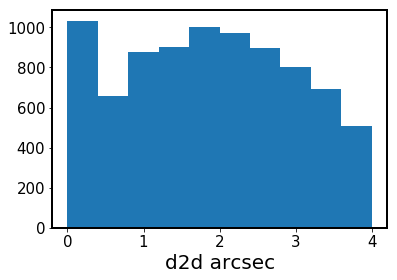

In [256]:
%matplotlib inline
plt.hist(stacked['d2d'][stacked['d2d']<4]) 
plt.xlabel('d2d arcsec')

In [257]:
# choose g,i,r,Y filters only ... 

# two visits should be in the same filter ... 
m1 = stacked['filterid_a'] == stacked['filterid_b'] 
# ... with frame location within 2 arcsec ...
m2 = stacked['d2d'] < 2 # arcsec 
# ... but observed at different dates 
m3 = stacked['date_a'] != stacked['date_b']
# ... finally, lets use only r band 
m4 = stacked['filterid_a'] == 'r.0000'
#m4 = stacked['exptime_a'] > 30 none that also satisfy this criterion... 
m = m1 * m2 * m3*  m4

# display the visits that fulfill the criteria above ... 
cols = ['ra_a','dec_a', 'ra_b', 'dec_b', 'exptime_a', 'exptime_b', 'date_a', 'date_b',
        'filterid_a', 'filterid_b', 'object_a', 'object_b', 'expnum_a', 'expnum_b']
stacked[m][cols]

ra_a,dec_a,ra_b,dec_b,exptime_a,exptime_b,date_a,date_b,filterid_a,filterid_b,object_a,object_b,expnum_a,expnum_b
float64,float64,float64,float64,float64,float64,str19,str19,str6,str6,str14,str14,int64,int64
141.905,-52.91109,141.9045,-52.91115,30.0,50.0,2016-03-19T22:26:29,2017-01-26T23:28:29,r.0000,r.0000,DECaPS_12281_r,DECaPS_12281_r,525906,609840
186.6497,-62.02707,186.6496,-62.02694,30.0,30.0,2016-03-19T22:32:02,2016-03-19T23:02:01,r.0000,r.0000,DECaPS_10319_r,DECaPS_10319_r,526085,527540
190.1646,-62.63993,190.1646,-62.63977,30.0,30.0,2016-03-19T22:32:19,2016-03-19T23:02:32,r.0000,r.0000,DECaPS_10312_r,DECaPS_10312_r,526094,527557
100.1654,-27.0729,100.1657,-27.07252,30.0,30.0,2016-03-19T22:34:51,2016-03-19T22:53:44,r.0000,r.0000,DECaPS_calib_1,DECaPS_calib_1,526288,527238
100.1657,-27.07252,100.1654,-27.0729,30.0,30.0,2016-03-19T22:53:44,2016-03-19T22:34:51,r.0000,r.0000,DECaPS_calib_1,DECaPS_calib_1,527238,526288
130.5827,-46.89543,130.5827,-46.89529,30.0,30.0,2016-03-19T22:53:51,2016-04-07T03:12:33,r.0000,r.0000,DECaPS_12346_r,DECaPS_12346_r,527244,529982
140.7048,-54.41988,140.7053,-54.42023,30.0,50.0,2016-03-19T22:54:38,2017-01-26T23:44:55,r.0000,r.0000,DECaPS_28136_r,DECaPS_28136_r,527272,611122
141.9048,-52.91147,141.9045,-52.91115,30.0,50.0,2016-03-19T22:54:41,2017-01-26T23:28:29,r.0000,r.0000,DECaPS_12281_r,DECaPS_12281_r,527273,609840
186.6496,-62.02694,186.6497,-62.02707,30.0,30.0,2016-03-19T23:02:01,2016-03-19T22:32:02,r.0000,r.0000,DECaPS_10319_r,DECaPS_10319_r,527540,526085


So there are 15 fields that fulfil these pretty choosy criteria. Let's compare the two!

In [258]:
# ok, so let's compare two visits in r, 30 sec each : 
i=11

filtr = stacked[m]['filterid_a'][i][:1]
print(filtr)

visits = {stacked[m]['expnum_a'][i]:'a', stacked[m]['expnum_b'][i]:'b'}

for visit in visits.keys() : 
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]

    print('The single-band catalog name corresponding to visit %d is %s' %(visit, cat_name))

    # the cat name is based on the image name ... 
    #image_name = 'c4d_170122_055542_ooi_g'
    #cat_name = image_name + '_v1.cat.fits'
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    file_name  = singleDir + cat_name

    # check if the catalog already exists
    if cat_name not in  os.listdir(singleDir) : 
        print('Downloading the catalog...')# if not, download it ...
        url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
        urllib.request.urlretrieve(url, file_name)

r
The single-band catalog name corresponding to visit 566770 is c4d_160824_003636_ooi_r_v1.cat.fits
The single-band catalog name corresponding to visit 567615 is c4d_160825_231544_ooi_r_v1.cat.fits


In [259]:
visits


{566770: 'a', 567615: 'b'}

Read in the catalogs...   Call them 'a' and 'b' 

In [260]:
decaps_data = {}
decaps_hdu_dic = {}
for visit in visits.keys(): 
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    print('\nThe single-band catalog name corresponding \
    to visit %d is %s' %(visit, cat_name))
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    file_name  = singleDir + cat_name
    
    #open the decaps catalog ...
    decaps_hdu = fits.open(file_name)
    band = visits[visit]
    decaps_hdu_dic[band] = decaps_hdu
    # decaps_hdu.info() would display all available tables - 
    # there is a single catalog per CCD, 
    # called 'S21_CAT', etc, based on CCD name. 
    print(visit)
    print(decaps_hdu[0].header['DATE-OBS'])
    print('ra=',decaps_hdu[0].header['RA'],'dec=',decaps_hdu[0].header['DEC'])
    
    # save the zero point for this catalog 
    decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
    print('For this catalog, zeropoint is ',decaps_zeropoint)
    # only XTENSION   'IMAGE' are the catalogs...
    # since I don't care here to compare exactly ccd-by-ccd to LSST, 
    # I just read in the decaps catalog for all the sources in the
    # full image mosaic. 
    arr = {'decaps_mag':[],'decaps_magerr':[],'ra':[],'dec':[], 'flags':[]}
    decaps_stack = Table(arr, names = ('decaps_mag', 'decaps_magerr',
                                           'ra', 'dec', 'flags'),
                            dtype = ('f8', 'f8','f8', 'f8', 'i8'))

    for i in range(1,len(decaps_hdu[:])) : 
        if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
            # if the i-th element is image ,
            # the catalog is i+2 element
            ccd_decaps_cat =  Table(decaps_hdu[i+2].data) 
            # convert the fluxes to magnitudes 
            ccd_decaps_cat['decaps_mag'] = -2.5 * np.log10(ccd_decaps_cat['flux'].data) +\
            decaps_zeropoint
            ccd_decaps_cat['decaps_magerr'] = (5.0 / (2*np.log(10))) * \
                ccd_decaps_cat['dflux'].data / ccd_decaps_cat['flux'].data

            # keep only the relevant info
            ccd_decaps = ccd_decaps_cat[['decaps_mag','decaps_magerr','ra','dec', 'flags']]
            decaps_stack = vstack([decaps_stack, ccd_decaps])

    decaps_stack.rename_column('ra', 'ra_decaps')
    decaps_stack.rename_column('dec', 'dec_decaps')
    
    # store the catalog for a given filter in a dictionary 
    band  = visits[visit]
    decaps_data[band] = decaps_stack


The single-band catalog name corresponding     to visit 566770 is c4d_160824_003636_ooi_r_v1.cat.fits
566770
2016-08-24T00:35:16.666863
ra= 15:19:59.90 dec= -25:00:00.1
For this catalog, zeropoint is  28.955


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10



The single-band catalog name corresponding     to visit 567615 is c4d_160825_231544_ooi_r_v1.cat.fits
567615
2016-08-25T23:14:23.100493
ra= 15:19:59.83 dec= -25:00:00.8
For this catalog, zeropoint is  28.833


In [262]:
#decaps

In [263]:
# check how many objects are in these two exposures...
for key in decaps_data.keys():
    print(len(decaps_data[key]))

162310
81251


There's something  wrong with these catalogs: given that they are pointing at exactly the same location on the sky, with the same exposure time, there shouldn't be such a difference in source counts .. 

In [200]:
# Show that they cover the same area...

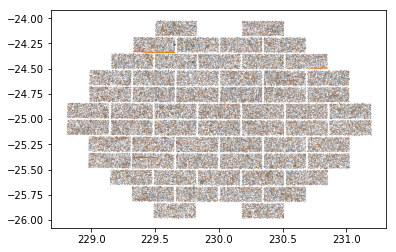

In [201]:
plt.scatter(decaps_data['a']['ra_decaps'],decaps_data['a']['dec_decaps'], s=0.001)
plt.scatter(decaps_data['b']['ra_decaps'],decaps_data['b']['dec_decaps'], s=0.001)



Ok, so they clearly cover the same area, but somehow the number of objects is so much greater in the other? Perhaps the catalog did not get fully downloaded ? 

In [64]:
#decaps_data['b']

In [87]:
#decaps_hdu.info()

In [264]:
decaps_clean = {}
# remove decaps detections with bad flags ...
for band in decaps_data.keys() : 
    mask_bad_pixels = decaps_data[band]['flags'] != 1
    mask_nan = np.bitwise_not(np.isnan(decaps_data[band]['decaps_mag']))
    mask_good_pixels = np.bitwise_not(mask_bad_pixels)
    mask = mask_nan * mask_good_pixels
    decaps_clean[band] = decaps_data[band][mask]

In [265]:
# now create a new catalog where we cross-matched the sources by ra,dec .. 
# one epoch:  a, to another epoch : b 
#
coord_1 = SkyCoord(ra  = decaps_clean['a']['ra_decaps']*u.degree, 
                       dec = decaps_clean['a']['dec_decaps']*u.degree)  
coord_2 = SkyCoord(ra  = decaps_clean['b']['ra_decaps']*u.degree, 
                       dec = decaps_clean['b']['dec_decaps']*u.degree)  

idx, d2d, d3d = coord_1.match_to_catalog_sky(coord_2)  

# stack the two catalogs 
ab = hstack([decaps_clean['a'] ,decaps_clean['b'][idx]],
               table_names=['a','b']  )

# make a column with separation in arcseconds ... 
ab['d2d'] = d2d.arcsec

(array([ 51217.,  13515.,   5493.,   2580.,   1492.,   1167.,   1252.,
          1581.,   1713.,   1736.]),
 array([  9.62291788e-05,   1.00075771e-01,   2.00055313e-01,
          3.00034856e-01,   4.00014398e-01,   4.99993940e-01,
          5.99973482e-01,   6.99953024e-01,   7.99932566e-01,
          8.99912108e-01,   9.99891651e-01]),
 <a list of 10 Patch objects>)

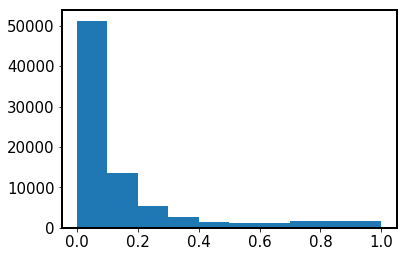

In [266]:
%matplotlib inline
plt.hist(ab['d2d'][ab['d2d']<1])

In [267]:
visit_a , visit_b = list(visits.keys())
print(visits)
print('visit a', visit_a, 'visit_b', visit_b)


{566770: 'a', 567615: 'b'}
visit a 566770 visit_b 567615


In [268]:
ab.write('r_30sec_'+str(visit_a)+'-'+str(visit_b)+'.dat', format = 'ascii')


(array([  7.82000000e+02,   1.90900000e+03,   3.86500000e+03,
          6.94900000e+03,   1.12830000e+04,   1.84400000e+04,
          3.38420000e+04,   1.32800000e+03,   3.90000000e+01,
          3.00000000e+00]),
 array([ 13.54245377,  14.67636452,  15.81027527,  16.94418602,
         18.07809677,  19.21200752,  20.34591827,  21.47982903,
         22.61373978,  23.74765053,  24.88156128]),
 <a list of 1 Patch objects>)

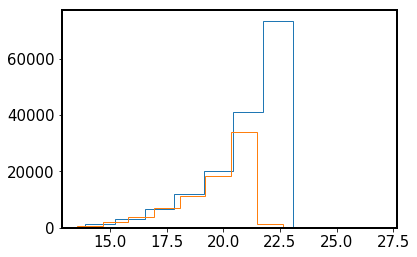

In [269]:
plt.hist(decaps_clean['a']['decaps_mag'], histtype='step')
plt.hist(decaps_clean['b']['decaps_mag'], histtype='step', )

In [270]:
# Select only those that are well matched... 
ab_sel = ab[ab['d2d']<0.5]

In [271]:
ab_sel['dmag'] = ab_sel['decaps_mag_a'] - ab_sel['decaps_mag_b']

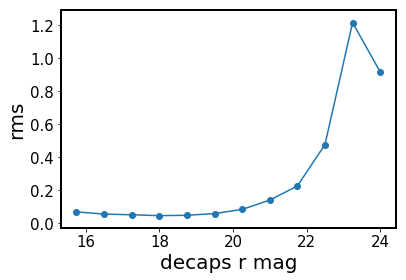

In [272]:
# plot the rms of photometry difference between the two epochs. ...
bins = np.arange(14,24,0.75)
# plot the photometric error vs magnitude ....
# calculate the rms only on sources that were matched... 
rms = lambda x : np.sqrt(np.mean(np.square(x)))
stat= bs(ab_sel['decaps_mag_a'],ab_sel['dmag'], bins=bins,statistic=rms)
fig,ax = plt.subplots()
ax.scatter(stat.bin_edges[2:]+0.25, stat.statistic[1:])
ax.plot(stat.bin_edges[2:]+0.25, stat.statistic[1:], label='rms')
ax.set_xlabel('decaps r mag')
ax.set_ylabel('rms')


In [273]:
files = np.array(os.listdir())
mask = np.array(['r_30sec_' in el for el in os.listdir()]).astype(bool)
r30_files = files[mask]

from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



## Plot rms 

r_30sec_526085-527540.dat
r_30sec_525906-609840.dat
r_30sec_527272-611122.dat
r_30sec_527273-609840.dat


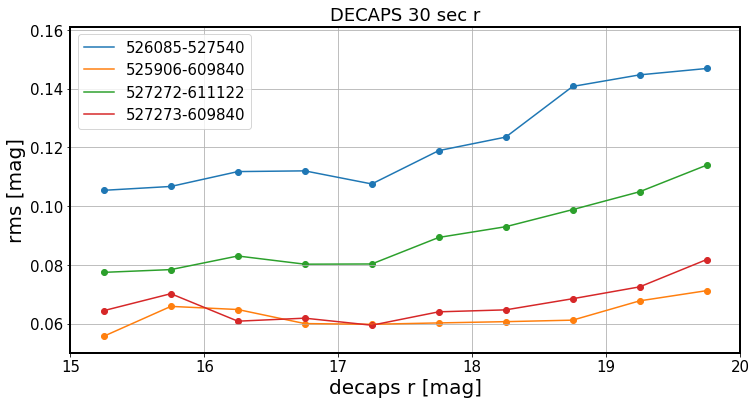

In [247]:
# create a figure 
fig,ax = plt.subplots(1,1,figsize=(12,6))
# plot the rms of photometry difference between the two epochs. ...
bins = np.arange(14,20,0.5)
# plot the photometric error vs magnitude ....
# calculate the rms only on sources that were matched... 
rms = lambda x : np.sqrt(np.mean(np.square(x)))

    
# Read in 
for i in [2,5,6,7]:
    fname = r30_files[i]
    print(fname)
    ab = Table.read(fname, format='ascii')

    # select those witha match within 0.5 arcsec 
    ab_sel = ab[ab['d2d']<0.5]
    ab_sel['dmag'] = ab_sel['decaps_mag_a'] - ab_sel['decaps_mag_b']
    
    # calculate the rms 
    stat= bs(ab_sel['decaps_mag_a'],ab_sel['dmag'], bins=bins,statistic=rms)

    # add to the plot 
    ax.scatter(stat.bin_edges[2:]+0.25, stat.statistic[1:])
    ax.plot(stat.bin_edges[2:]+0.25, stat.statistic[1:], 
            label=fname[len('r_30sec_'):-len('.dat')])

ax.set_xlabel('decaps r [mag]')
ax.set_ylabel('rms [mag]')
ax.set_title('DECAPS 30 sec r')
ax.grid()
plt.legend()
plt.savefig('decaps_rms_r-30sec_two_epochs_zoom.png', bbox_inches='tight')



## Plot $\sigma_{G}$

r_30sec_526085-527540.dat
r_30sec_525906-609840.dat
r_30sec_527272-611122.dat
r_30sec_527273-609840.dat


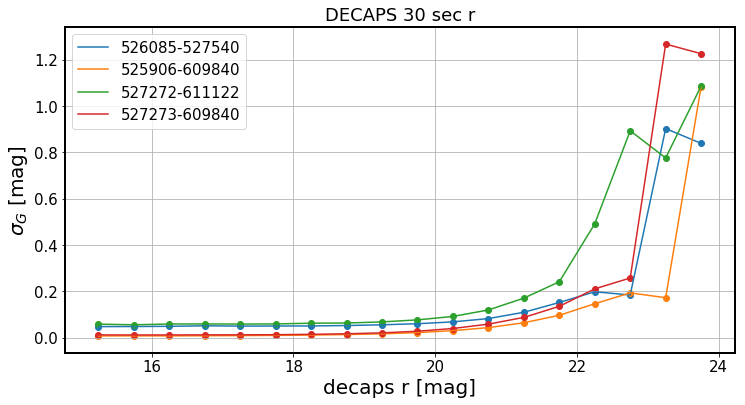

In [343]:
# create a figure 
fig,ax = plt.subplots(1,1,figsize=(12,6))
bins = np.arange(14,24,0.5) # (14,20,0.5)

# Read in 
for i in [2,5,6,7]:
    fname = r30_files[i]
    print(fname)
    ab = Table.read(fname, format='ascii')

    # select those witha match within 0.5 arcsec 
    ab_sel = ab[ab['d2d']<0.5]
    ab_sel['dmag'] = ab_sel['decaps_mag_a'] - ab_sel['decaps_mag_b']
    
    # calculate the rms 
    stat= bs(ab_sel['decaps_mag_a'],ab_sel['dmag'], bins=bins,statistic=sigmaG)

    # add to the plot 
    ax.scatter(stat.bin_edges[2:]+0.25, stat.statistic[1:])
    ax.plot(stat.bin_edges[2:]+0.25, stat.statistic[1:], 
            label=fname[len('r_30sec_'):-len('.dat')])

ax.set_xlabel('decaps r [mag]')
ax.set_ylabel(r'$\sigma_{G}$'+' [mag]')
ax.set_title('DECAPS 30 sec r')
ax.grid()
plt.legend()
plt.savefig('decaps_sigmaG_r-30sec_two_epochs.png', bbox_inches='tight')




In [337]:
print('We are dealing with ', fname )
# Want to plot the histogram of delta mag for each bin....
ab_sel = ab[ab['d2d']<0.5]
ab_sel['dmag'] = ab_sel['decaps_mag_a'] - ab_sel['decaps_mag_b']

# calculate the rms 
stat= bs(ab_sel['decaps_mag_a'],ab_sel['dmag'], bins=bins,statistic=rms)

print(len(stat.binnumber))
print(bins)
print(stat.bin_edges)
# Check what bin numbers are available ...
print(np.unique(stat.binnumber))

We are dealing with  r_30sec_527273-609840.dat
727005
[ 14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.   18.5  19.   19.5]
[ 14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.   18.5  19.   19.5]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In this bin there are  43944  objects


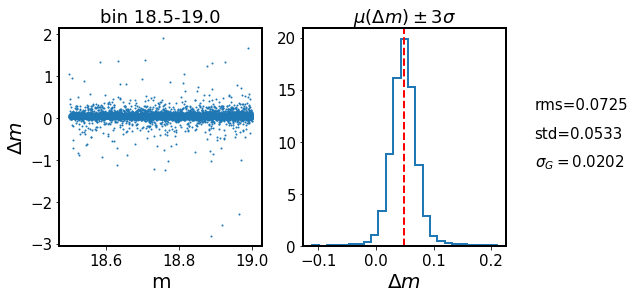

In [352]:
# plot the histogram of chosen bin, 
# calculate the std, rms, mean, etc. 
# limit the histogram to mean +/- 3 std , because otherwise
# outliers affect us too much ... 

bin_number = 10
mask_rows =  stat.binnumber == bin_number
print('In this bin there are ' ,np.sum(mask_rows), ' objects')
fig,ax = plt.subplots(1,2,figsize=(8,4))
y = ab_sel['dmag'][mask_rows]
ax[0].scatter(ab_sel['decaps_mag_a'][mask_rows], y,s=1 )
ax[0].set_title('bin '\
                +str(bins[bin_number-1])+'-'+str(bins[bin_number]))
ax[0].set_ylabel(r'$\Delta m$')
ax[0].set_xlabel('m')
mean = np.mean(y)
std = np.std(y)
ax[1].hist(ab_sel['dmag'][mask_rows], bins=25, 
           range=[mean-3*std,mean+3*std], normed=True,
          histtype='step', lw=2)
ax[1].axvline(mean,ls='--', c='red', lw=2)
ax[1].set_title(r'$\mu(\Delta m) \pm 3 \sigma$')
ax[1].set_xlabel(r'$\Delta m$')
N = 6
fig.text(0.95,0.6,'rms='+str(rms(y))[:N])
fig.text(0.95,0.5,'std='+str(std)[:N])
fig.text(0.95,0.4,r'$\sigma_{G}=$'+str(sigmaG(y))[:N])
fig.subplots_adjust(wspace=0.2)
plt.savefig('decaps_r-30sec_two_epochs_bin'+str(bin_number)+'_hist.png', 
            bbox_inches='tight')

In [348]:
str(bins[bin_number-1])+'-'+str(bins[bin_number])

'16.5-17.0'

In [297]:
np.sqrt(np.mean(np.square(y)))

0.045954354450136868

In [298]:
sigma_clipped_stats?

In [302]:
from astroML.stats._point_statistics import sigmaG
sigmaG(y)

0.01144285178600868

In [303]:
np.mean(y)

0.040934154964606471

In [304]:
np.median(y)

0.04048919677734375